In [194]:
# --- Import needed libraries ---
import pandas as pd
import numpy as np
import os
from glob import glob
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, f1_score, root_mean_squared_error, classification_report, log_loss
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import csv
from xgboost import XGBClassifier
from datetime import datetime

In [195]:
# --- Configuration ---
DATA_DIR = "dataset"
SEASONS = ["18_19", "19_20", "20_21", "21_22", "22_23", "23_24"]
LEAGUES = ["E0", "F1", "D1", "I1", "SP1"]  # EPL, Ligue 1, Bundesliga, Serie A, La Liga

In [196]:
# --- Load Data ---
def load_all_data():
    all_data = []
    for season in SEASONS:
        for league in LEAGUES:
            # Search recursively for matching files
            pattern = os.path.join(DATA_DIR, '**', f"{league}_{season}.csv")
            for path in glob(pattern, recursive=True):
                df = pd.read_csv(path)
                df['Season'] = season
                df['League'] = league
                all_data.append(df)
    return pd.concat(all_data, ignore_index=True)


--- RAW DATA INFO ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10781 entries, 0 to 10780
Columns: 126 entries, Div to AvgCAHA
dtypes: float64(100), int64(16), object(10)
memory usage: 10.4+ MB
None

--- RAW DATA HEAD ---
  Div        Date      HomeTeam        AwayTeam  FTHG  FTAG FTR  HTHG  HTAG  \
0  E0  10/08/2018    Man United       Leicester     2     1   H     1     0   
1  E0  11/08/2018   Bournemouth         Cardiff     2     0   H     1     0   
2  E0  11/08/2018        Fulham  Crystal Palace     0     2   A     0     1   
3  E0  11/08/2018  Huddersfield         Chelsea     0     3   A     0     2   
4  E0  11/08/2018     Newcastle       Tottenham     1     2   A     1     2   

  HTR  ... AvgC<2.5  AHCh  B365CAHH  B365CAHA  PCAHH  PCAHA  MaxCAHH  MaxCAHA  \
0   H  ...      NaN   NaN       NaN       NaN    NaN    NaN      NaN      NaN   
1   H  ...      NaN   NaN       NaN       NaN    NaN    NaN      NaN      NaN   
2   A  ...      NaN   NaN       NaN       NaN    Na

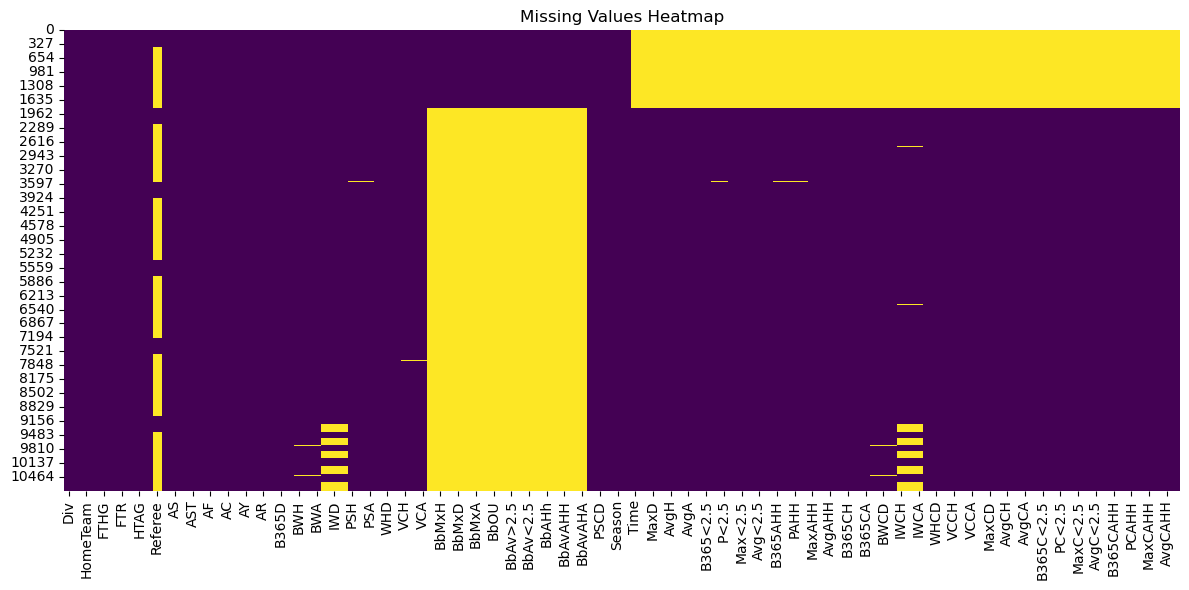

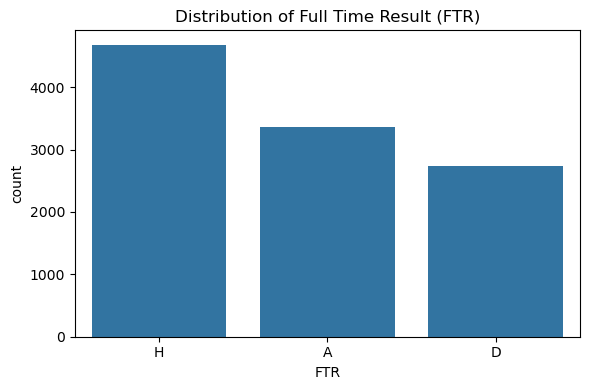

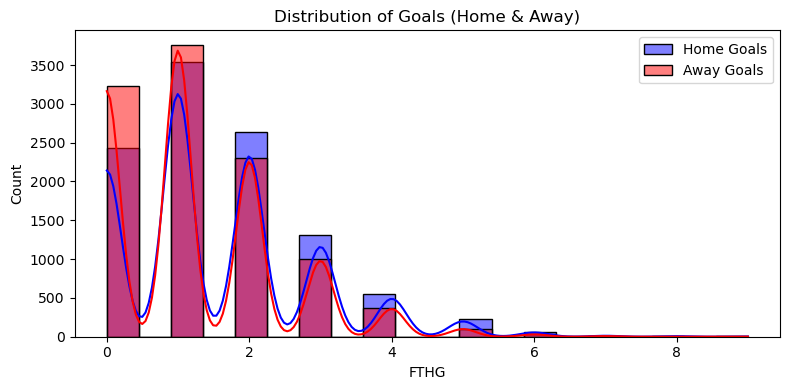

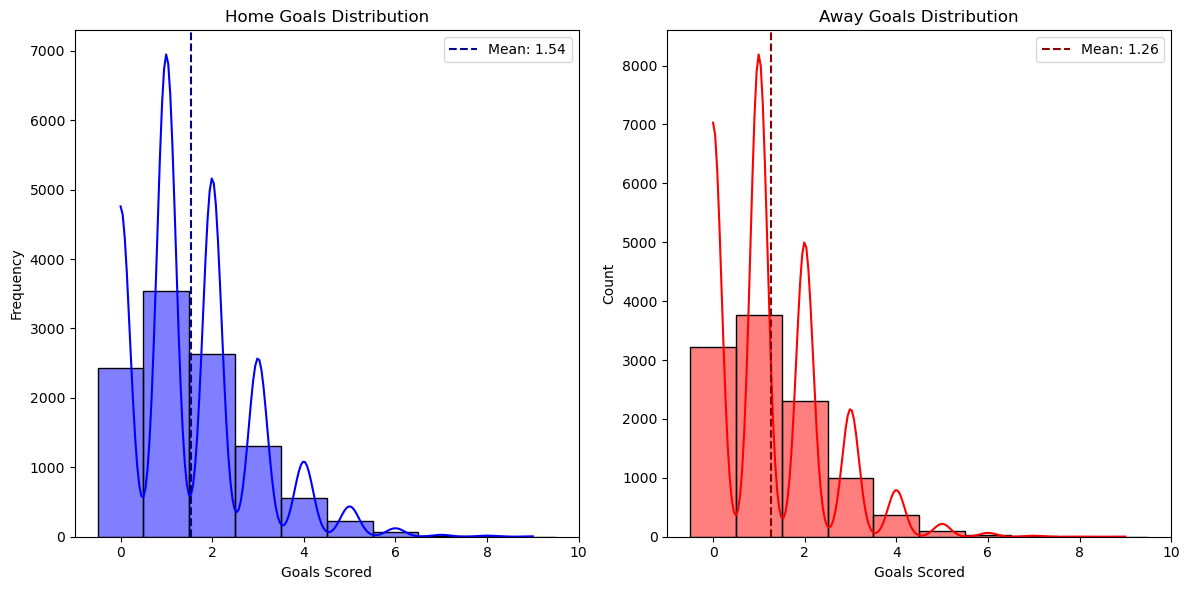


Goal Statistics:
Average home goals: 1.54
Average away goals: 1.26
Most common home goals: 1
Most common away goals: 1
Home goals std. dev: 1.30
Away goals std. dev: 1.17


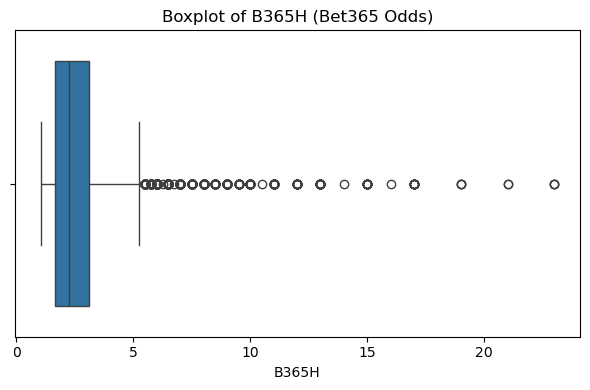

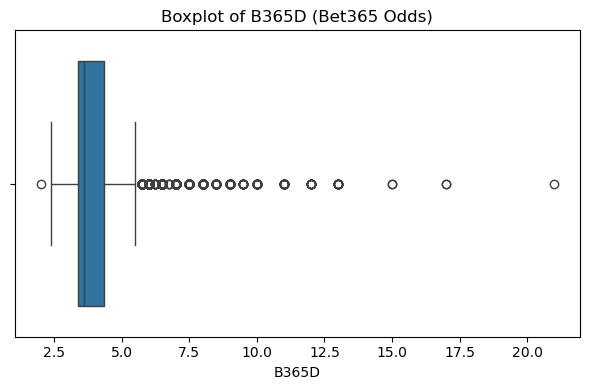

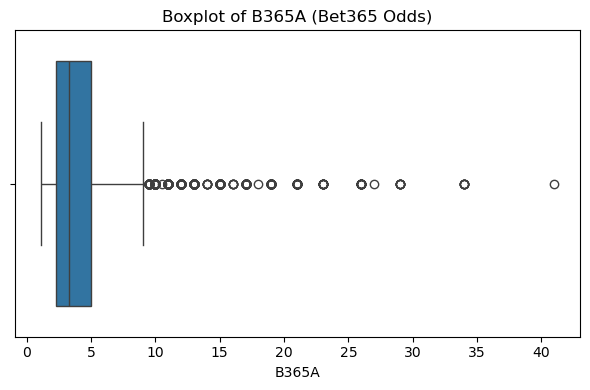

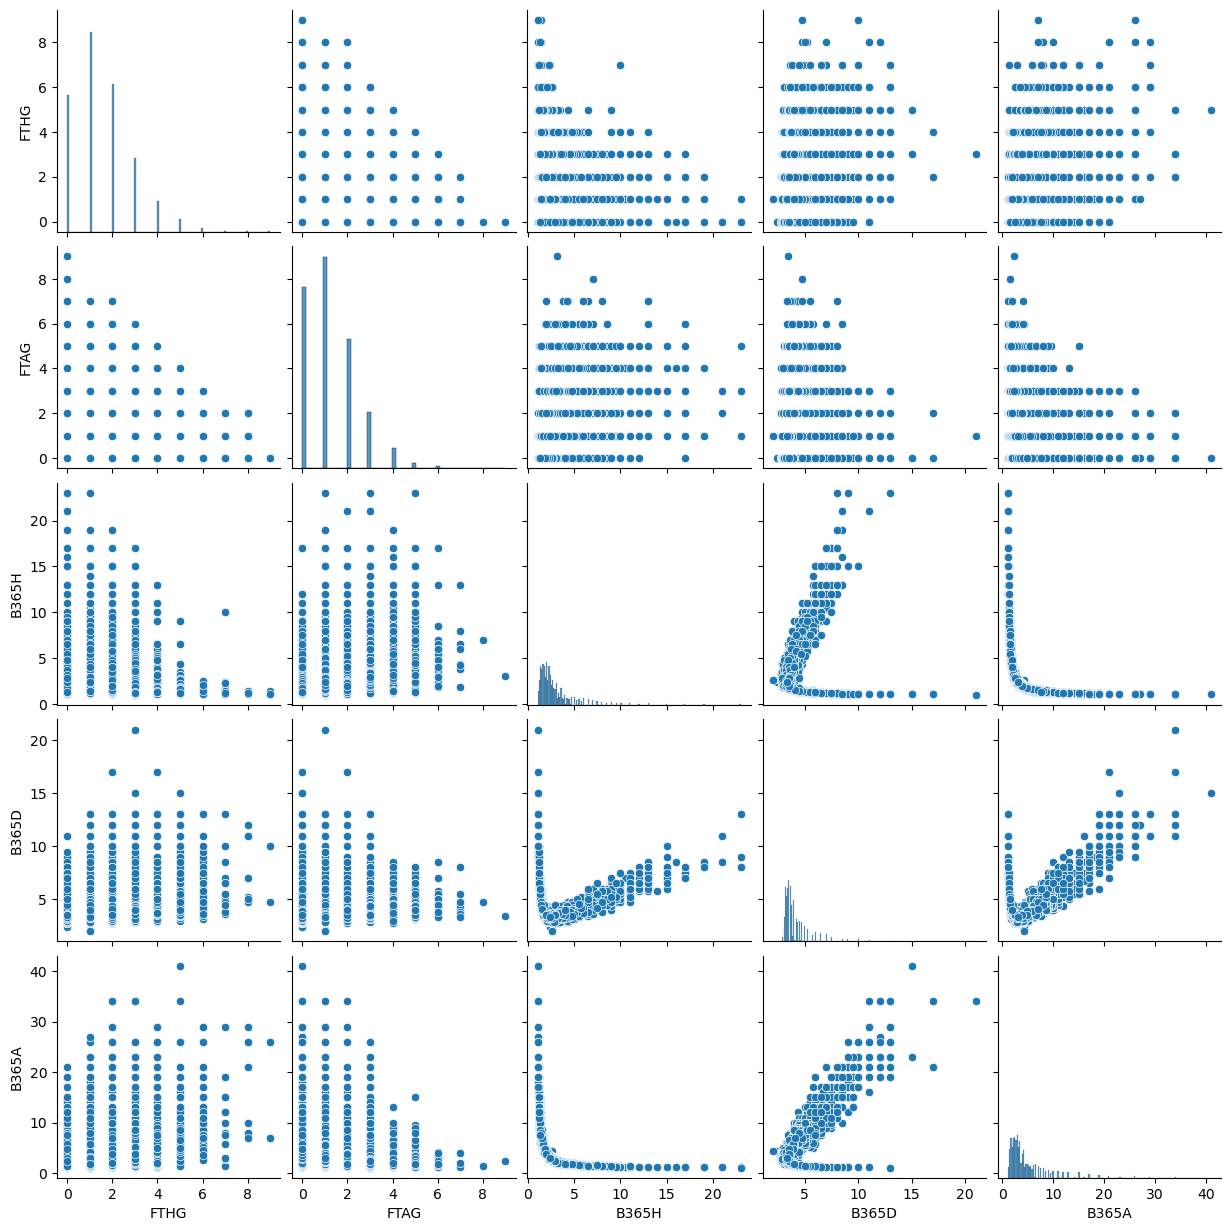

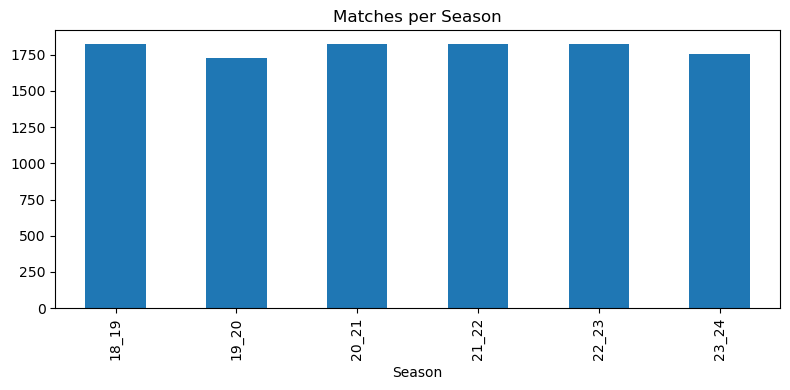

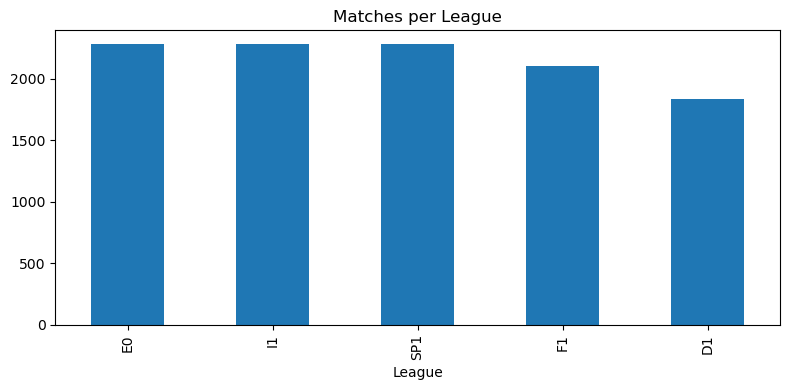

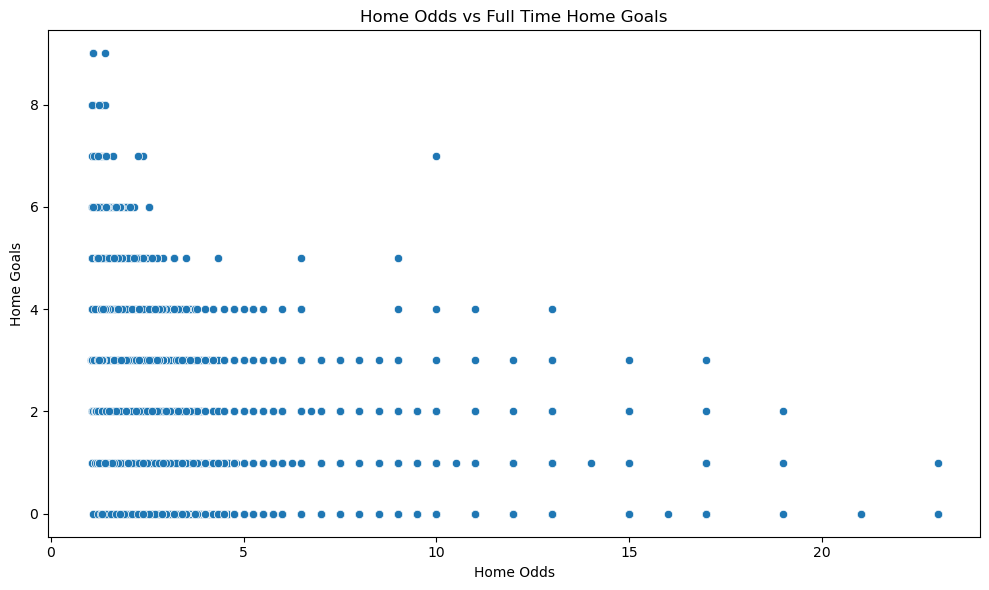

EDA outputs saved to 'outputs/' folder.


In [197]:
# --- Deep Exploratory Data Analysis (EDA) ---

def deep_eda(df):
    print("\n--- RAW DATA INFO ---")
    print(df.info())
    print("\n--- RAW DATA HEAD ---")
    print(df.head())
    print("\n--- RAW DATA DESCRIBE ---")
    print(df.describe(include='all'))

    # Save outputs
    os.makedirs("outputs", exist_ok=True)
    df.describe(include='all').to_csv("outputs/eda_raw_describe.csv")

    # Missing values heatmap
    plt.figure(figsize=(12, 6))
    sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
    plt.title('Missing Values Heatmap')
    plt.tight_layout()
    plt.savefig("outputs/eda_missing_heatmap.png")
    plt.show()

    # Distribution of target variable (FTR)
    if 'FTR' in df.columns:
        plt.figure(figsize=(6, 4))
        sns.countplot(x='FTR', data=df)
        plt.title('Distribution of Full Time Result (FTR)')
        plt.tight_layout()
        plt.savefig("outputs/eda_ftr_distribution.png")
        plt.show()

    # Distribution of goals
    if 'FTHG' in df.columns and 'FTAG' in df.columns:
        plt.figure(figsize=(8, 4))
        sns.histplot(df['FTHG'], bins=20, kde=True, color='blue', label='Home Goals')
        sns.histplot(df['FTAG'], bins=20, kde=True, color='red', label='Away Goals')
        plt.legend()
        plt.title('Distribution of Goals (Home & Away)')
        plt.tight_layout()
        plt.savefig("outputs/eda_goals_distribution.png")
        plt.show()

     # Distribution of goals alternative
    if 'FTHG' in df.columns and 'FTAG' in df.columns:
        plt.figure(figsize=(12, 6))
    
        # Create subplots
        plt.subplot(1, 2, 1)
        sns.histplot(df['FTHG'], bins=range(0, df['FTHG'].max()+2), 
                 kde=True, color='blue', discrete=True)
        plt.title('Home Goals Distribution')
        plt.xlabel('Goals Scored')
        plt.ylabel('Frequency')
    
        # Add mean line for home goals
        mean_home = df['FTHG'].mean()
        plt.axvline(mean_home, color='darkblue', linestyle='--', 
                label=f'Mean: {mean_home:.2f}')
        plt.legend()
    
        plt.subplot(1, 2, 2)
        sns.histplot(df['FTAG'], bins=range(0, df['FTAG'].max()+2), 
                 kde=True, color='red', discrete=True)
        plt.title('Away Goals Distribution')
        plt.xlabel('Goals Scored')
    
        # Add mean line for away goals
        mean_away = df['FTAG'].mean()
        plt.axvline(mean_away, color='darkred', linestyle='--', 
                label=f'Mean: {mean_away:.2f}')
        plt.legend()
    
        plt.tight_layout()
    
        # Save and show
        plt.savefig("outputs/eda_goals_distribution.png", dpi=300, bbox_inches='tight')
        plt.show()
    
    # Additional statistics
    print("\nGoal Statistics:")
    print(f"Average home goals: {mean_home:.2f}")
    print(f"Average away goals: {mean_away:.2f}")
    print(f"Most common home goals: {df['FTHG'].mode()[0]}")
    print(f"Most common away goals: {df['FTAG'].mode()[0]}")
    print(f"Home goals std. dev: {df['FTHG'].std():.2f}")
    print(f"Away goals std. dev: {df['FTAG'].std():.2f}")

    # Boxplots for odds
    for col in ['B365H', 'B365D', 'B365A']:
        if col in df.columns:
            plt.figure(figsize=(6, 4))
            sns.boxplot(x=df[col])
            plt.title(f'Boxplot of {col} (Bet365 Odds)')
            plt.tight_layout()
            plt.savefig(f"outputs/eda_boxplot_{col}.png")
            plt.show()

    # Pairplot for selected features (if not too many rows)
    selected = ['FTHG', 'FTAG', 'B365H', 'B365D', 'B365A']
    selected = [col for col in selected if col in df.columns]
    if len(selected) > 1:
        sns.pairplot(df[selected].dropna())
        plt.savefig("outputs/eda_pairplot.png")
        plt.show()


    # Season and league distribution
    if 'Season' in df.columns:
        plt.figure(figsize=(8, 4))
        df['Season'].value_counts().sort_index().plot(kind='bar')
        plt.title('Matches per Season')
        plt.tight_layout()
        plt.savefig("outputs/eda_season_distribution.png")
        plt.show()
    if 'League' in df.columns:
        plt.figure(figsize=(8, 4))
        df['League'].value_counts().plot(kind='bar')
        plt.title('Matches per League')
        plt.tight_layout()
        plt.savefig("outputs/eda_league_distribution.png")
        plt.show()


    # Scatter plot of odds vs. goals
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='B365H', y='FTHG', data=df)
    plt.title('Home Odds vs Full Time Home Goals')
    plt.xlabel('Home Odds')
    plt.ylabel('Home Goals')
    plt.tight_layout()
    plt.savefig("outputs/scatter_odds_vs_goals.png")
    plt.show()

    
    print("EDA outputs saved to 'outputs/' folder.")

# --- Load raw data and run deep EDA ---
raw_df = load_all_data()
deep_eda(raw_df)

In [198]:
# --- Feature Engineering for Team Form ---
def add_team_form_features(df, n_matches=6):
    df = df.sort_values(['Season', 'League', 'Date'])  # Ensure chronological order if 'Date' exists
    # If 'Date' is not present, sort by season, league, and match index

    # Points mapping
    result_points = {'H': 3, 'D': 1, 'A': 0}

    # Initialize form columns
    df['HomeTeam_FormPts'] = np.nan
    df['AwayTeam_FormPts'] = np.nan
    df['HomeTeam_FormGS'] = np.nan  # Goals scored
    df['AwayTeam_FormGS'] = np.nan
    df['HomeTeam_FormGC'] = np.nan  # Goals conceded
    df['AwayTeam_FormGC'] = np.nan

    # Group by team and calculate rolling stats
    for team in df['HomeTeam'].unique():
        home_matches = df[df['HomeTeam'] == team].sort_index()
        away_matches = df[df['AwayTeam'] == team].sort_index()
        all_matches = pd.concat([home_matches, away_matches]).sort_index()

        # Points in last n matches
        def get_points(row):
            if row['HomeTeam'] == team and row['FTR'] == 'H':
                return result_points['H']
            elif row['AwayTeam'] == team and row['FTR'] == 'A':
                return result_points['A']
            elif (row['HomeTeam'] == team or row['AwayTeam'] == team) and row['FTR'] == 'D':
                return result_points['D']
            else:
                return np.nan

        points = all_matches.apply(get_points, axis=1)
        rolling_points = points.shift(1).rolling(n_matches, min_periods=1).mean()
        goals_scored = np.where(all_matches['HomeTeam'] == team, all_matches['FTHG'], all_matches['FTAG'])
        goals_conceded = np.where(all_matches['HomeTeam'] == team, all_matches['FTAG'], all_matches['FTHG'])
        rolling_gs = pd.Series(goals_scored, index=all_matches.index).shift(1).rolling(n_matches, min_periods=1).mean()
        rolling_gc = pd.Series(goals_conceded, index=all_matches.index).shift(1).rolling(n_matches, min_periods=1).mean()

        # Assign back to main df
        idx = all_matches.index
        df.loc[idx, 'Team_FormPts'] = rolling_points.values
        df.loc[idx, 'Team_FormGS'] = rolling_gs.values
        df.loc[idx, 'Team_FormGC'] = rolling_gc.values

    # Assign home/away form features
    df['HomeTeam_FormPts'] = df.groupby('HomeTeam')['Team_FormPts'].transform('last')
    df['AwayTeam_FormPts'] = df.groupby('AwayTeam')['Team_FormPts'].transform('last')
    df['HomeTeam_FormGS'] = df.groupby('HomeTeam')['Team_FormGS'].transform('last')
    df['AwayTeam_FormGS'] = df.groupby('AwayTeam')['Team_FormGS'].transform('last')
    df['HomeTeam_FormGC'] = df.groupby('HomeTeam')['Team_FormGC'].transform('last')
    df['AwayTeam_FormGC'] = df.groupby('AwayTeam')['Team_FormGC'].transform('last')

    # Drop helper columns
    df = df.drop(columns=['Team_FormPts', 'Team_FormGS', 'Team_FormGC'])

    return df

In [199]:
def add_goal_superiority_feature(df, n_matches=6):
    # Ensure chronological order
    if 'Date' in df.columns:
        df = df.sort_values(['Season', 'League', 'Date'])
    else:
        df = df.sort_values(['Season', 'League']).reset_index(drop=True)

    # Prepare columns
    df['Home_GoalSup'] = np.nan
    df['Away_GoalSup'] = np.nan
    df['Match_GoalSup'] = np.nan

    # For each team, calculate rolling sums
    for team in pd.unique(df[['HomeTeam', 'AwayTeam']].values.ravel('K')):
        team_matches = df[(df['HomeTeam'] == team) | (df['AwayTeam'] == team)].sort_index()

        # Goals scored and conceded per match
        goals_scored = np.where(team_matches['HomeTeam'] == team, team_matches['FTHG'], team_matches['FTAG'])
        goals_conceded = np.where(team_matches['HomeTeam'] == team, team_matches['FTAG'], team_matches['FTHG'])

        # Rolling sums (excluding current match)
        rolling_scored = pd.Series(goals_scored, index=team_matches.index).shift(1).rolling(n_matches, min_periods=1).sum()
        rolling_conceded = pd.Series(goals_conceded, index=team_matches.index).shift(1).rolling(n_matches, min_periods=1).sum()
        goal_sup = rolling_scored - rolling_conceded

        # Assign to main df
        for idx in team_matches.index:
            if df.at[idx, 'HomeTeam'] == team:
                df.at[idx, 'Home_GoalSup'] = goal_sup.loc[idx]
            if df.at[idx, 'AwayTeam'] == team:
                df.at[idx, 'Away_GoalSup'] = goal_sup.loc[idx]

    # Calculate match goal superiority
    df['Match_GoalSup'] = df['Home_GoalSup'] - df['Away_GoalSup']
    return df

In [200]:
# --- Feature Engineering ---
def engineer_features(df):
    df = df.dropna(subset=['FTR', 'HomeTeam', 'AwayTeam'])
    df = add_team_form_features(df)
    df = add_goal_superiority_feature(df, n_matches=6)
    # Convert 'Date' to numeric (ordinal) if present
    if 'Date' in df.columns:
        df['Date'] = pd.to_datetime(df['Date'], dayfirst=True, errors='coerce')
        df['Date'] = df['Date'].map(lambda x: x.toordinal() if pd.notnull(x) else np.nan)
    # Add new features to the selected columns
    feature_cols = [
        'Date',
        'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR',
        'B365H', 'B365D', 'B365A', 'Season', 'League',
        'HomeTeam_FormPts', 'AwayTeam_FormPts',
        'HomeTeam_FormGS', 'AwayTeam_FormGS',
        'HomeTeam_FormGC', 'AwayTeam_FormGC',
        'Home_GoalSup', 'Away_GoalSup', 'Match_GoalSup' 
    ]
    # Only keep columns that exist in the dataframe
    feature_cols = [col for col in feature_cols if col in df.columns]
    df = df[feature_cols]

    # Implied Probabilities
    df['Imp_H'] = 1 / df['B365H']
    df['Imp_D'] = 1 / df['B365D']
    df['Imp_A'] = 1 / df['B365A']
    
    # Normalize to sum to 1
    total = df[['Imp_H', 'Imp_D', 'Imp_A']].sum(axis=1)
    df['Imp_H'] /= total
    df['Imp_D'] /= total
    df['Imp_A'] /= total

    # Encode result
    df['Result'] = df['FTR'].map({'H': 0, 'D': 1, 'A': 2})

    # Encode teams
    le = LabelEncoder()
    df['HomeTeam'] = le.fit_transform(df['HomeTeam'])
    home_team_encoder = le  # Save encoder for later use
    le2 = LabelEncoder()
    df['AwayTeam'] = le2.fit_transform(df['AwayTeam'])
    away_team_encoder = le2  # Save encoder for later use

    # Encode League and Season
    df['League'] = LabelEncoder().fit_transform(df['League'])
    df['Season'] = LabelEncoder().fit_transform(df['Season'])

    return df.dropna(), home_team_encoder, away_team_encoder

In [201]:
# --- Correlation Matrix ---
def perform_eda(df):
    corr_cols = [
        'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'Imp_H', 'Imp_D', 'Imp_A', 'Result',
        'HomeTeam_FormPts', 'AwayTeam_FormPts',
        'HomeTeam_FormGS', 'AwayTeam_FormGS',
        'HomeTeam_FormGC', 'AwayTeam_FormGC',
        'Home_GoalSup', 'Away_GoalSup', 'Match_GoalSup'
    ]

    # Correlation matrix
    plt.figure(figsize=(10, 6))
    # corr = df[['HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'Imp_H', 'Imp_D', 'Imp_A', 'Result']].corr()
    corr_cols = [col for col in corr_cols if col in df.columns]
    corr = df[corr_cols].corr()
    plt.figure(figsize=(14, 10))
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Feature Correlation Matrix')
    plt.tight_layout()
    plt.savefig("outputs/correlation_matrix.png")
    plt.show()

    # Save correlation matrix to outputs folder
    corr.to_csv("outputs/eda_correlations.csv")

<Figure size 1000x600 with 0 Axes>

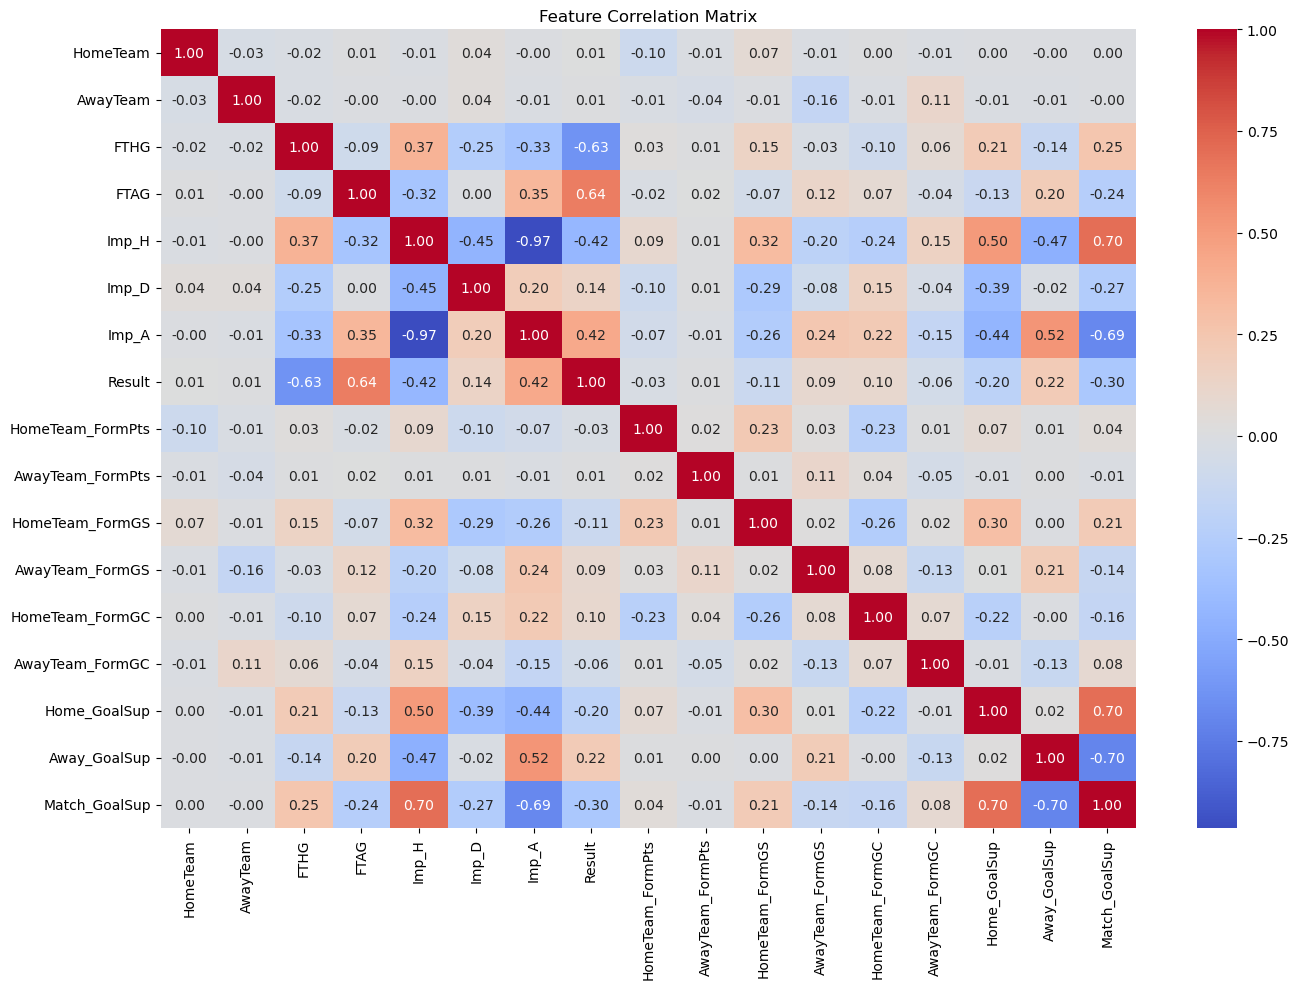

In [202]:
df = load_all_data()
df, home_team_encoder, away_team_encoder = engineer_features(df)
perform_eda(df)

In [203]:
# --- Split Train/Test ---
def split_data(df):
    test_season = df['Season'].max()
    train_df = df[df['Season'] < test_season]
    test_df = df[df['Season'] == test_season]
    X_train = train_df.drop(columns=['FTR', 'FTHG', 'FTAG', 'Result'])
    y_train = train_df['Result']
    X_test = test_df.drop(columns=['FTR', 'FTHG', 'FTAG', 'Result'])
    y_test = test_df['Result']
    return X_train, X_test, y_train, y_test

In [204]:
df = load_all_data()
df, home_team_encoder, away_team_encoder = engineer_features(df)
if 'Date' in df.columns:
    df['Date'] = pd.to_datetime(df['Date'], dayfirst=True, errors='coerce')
    df['Date'] = df['Date'].map(lambda x: x.toordinal() if pd.notnull(x) else np.nan)
X_train, X_test, y_train, y_test = split_data(df)
print("Features used for training:", X_train.columns.tolist())

Features used for training: ['Date', 'HomeTeam', 'AwayTeam', 'B365H', 'B365D', 'B365A', 'Season', 'League', 'HomeTeam_FormPts', 'AwayTeam_FormPts', 'HomeTeam_FormGS', 'AwayTeam_FormGS', 'HomeTeam_FormGC', 'AwayTeam_FormGC', 'Home_GoalSup', 'Away_GoalSup', 'Match_GoalSup', 'Imp_H', 'Imp_D', 'Imp_A']


In [205]:
# --- Model Training and Evaluation ---
def train_and_evaluate(X_train, X_test, y_train, y_test):
    results = []
    models = {
        'Logistic Regression': LogisticRegression(max_iter=20000),
        'Random Forest': RandomForestClassifier(n_estimators=1000, random_state=42),
        'SVM': SVC(kernel='rbf'),
        'MLP': MLPClassifier(
            hidden_layer_sizes=(128, 64),
            activation='relu',
            solver='adam',
            alpha=0.0005,
            learning_rate_init=0.001,
            max_iter=500,
            early_stopping=True,
            random_state=42
        ),
        'XGBoost': XGBClassifier(
            n_estimators=100,
            learning_rate=0.1,
            max_depth=5,
            use_label_encoder=False,
            eval_metric='mlogloss',
            random_state=42
        )
    }
    
    for name, model in models.items():
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        # For log loss, we need probability estimates
        if hasattr(model, "predict_proba"):
            pred_probs = model.predict_proba(X_test)
        else:  # For models without probability estimates (like SVM)
            pred_probs = model.decision_function(X_test)
        # Convert to probabilities using softmax
        pred_probs = np.exp(pred_probs) / np.sum(np.exp(pred_probs), axis=1, keepdims=True)
        # Calculate metrics
        acc = accuracy_score(y_test, preds)
        f1 = f1_score(y_test, preds, average='macro')
        rmse = np.sqrt(root_mean_squared_error(y_test, preds))
        loss = log_loss(y_test, pred_probs)
        print(f"\n{name}")
        print(f"Accuracy: {acc:.2f}, F1 Score: {f1:.2f}, RMSE: {rmse:.2f}, Log Loss: {loss:.2f}")
        print(classification_report(y_test, preds))
        results.append([name, acc, f1, rmse, loss])

    # Save results to CSV
    with open("outputs/model_evaluation.csv", "w", newline='') as f:
        writer = csv.writer(f)
        writer.writerow(["Model", "Accuracy", "F1 Score", "RMSE", "Log Loss"])
        writer.writerows(results)

In [206]:
# --- Main Pipeline ---
def main():
    df = load_all_data()
    df, home_team_encoder, away_team_encoder = engineer_features(df)
    # perform_eda(df)
    # Convert 'Date' to numeric (ordinal) if present
    if 'Date' in df.columns:
        df['Date'] = pd.to_datetime(df['Date'], dayfirst=True, errors='coerce')
        df['Date'] = df['Date'].map(lambda x: x.toordinal() if pd.notnull(x) else np.nan)
    X_train, X_test, y_train, y_test = split_data(df)
    train_and_evaluate(X_train, X_test, y_train, y_test)

if __name__ == "__main__":
    main()

c:\Users\Usuario\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\Usuario\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Usuario\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0


Logistic Regression
Accuracy: 0.54, F1 Score: 0.41, RMSE: 1.01, Log Loss: 1.03
              precision    recall  f1-score   support

           0       0.54      0.88      0.66       752
           1       0.00      0.00      0.00       461
           2       0.56      0.54      0.55       534

    accuracy                           0.54      1747
   macro avg       0.37      0.47      0.41      1747
weighted avg       0.40      0.54      0.46      1747


Random Forest
Accuracy: 0.53, F1 Score: 0.45, RMSE: 1.00, Log Loss: 1.03
              precision    recall  f1-score   support

           0       0.55      0.79      0.65       752
           1       0.31      0.10      0.15       461
           2       0.54      0.54      0.54       534

    accuracy                           0.53      1747
   macro avg       0.47      0.47      0.45      1747
weighted avg       0.49      0.53      0.48      1747


SVM
Accuracy: 0.43, F1 Score: 0.20, RMSE: 1.10, Log Loss: 1.34
              precis

c:\Users\Usuario\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Usuario\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Usuario\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



MLP
Accuracy: 0.43, F1 Score: 0.20, RMSE: 1.10, Log Loss: 1.12
              precision    recall  f1-score   support

           0       0.43      1.00      0.60       752
           1       0.00      0.00      0.00       461
           2       0.00      0.00      0.00       534

    accuracy                           0.43      1747
   macro avg       0.14      0.33      0.20      1747
weighted avg       0.19      0.43      0.26      1747



c:\Users\Usuario\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Usuario\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Usuario\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Usuario\anaconda3\Lib\sit


XGBoost
Accuracy: 0.53, F1 Score: 0.42, RMSE: 1.00, Log Loss: 1.02
              precision    recall  f1-score   support

           0       0.55      0.82      0.66       752
           1       0.19      0.03      0.05       461
           2       0.54      0.55      0.55       534

    accuracy                           0.53      1747
   macro avg       0.43      0.47      0.42      1747
weighted avg       0.45      0.53      0.46      1747



In [279]:
# --- Prepare test_df and test_probs for betting simulation ---

# 1. Load and process data
df = load_all_data()
df, home_team_encoder, away_team_encoder = engineer_features(df)

# 2. Split data
test_season = df['Season'].max()
train_df = df[df['Season'] < test_season]
test_df = df[df['Season'] == test_season]  # This is your test_df

X_train = train_df.drop(columns=['FTR', 'FTHG', 'FTAG', 'Result'])
y_train = train_df['Result']
X_test = test_df.drop(columns=['FTR', 'FTHG', 'FTAG', 'Result'])
y_test = test_df['Result']

# 3. Train Logistic Regression and get probabilities
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
lr_probs = lr.predict_proba(X_test)  



c:\Users\Usuario\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
# --- Simulate Betting Strategy for LR ---

# Assume you have: test_df, test_probs (from your LR model), and X_test indices match test_df
bet_results = []
stake = 1  # 1 unit per bet

# Add predicted probabilities to test_df
prob_cols = ['Prob_H', 'Prob_D', 'Prob_A']
probs_df = pd.DataFrame(lr_probs, columns=prob_cols)
sim_df = test_df.reset_index(drop=True).copy()
sim_df = pd.concat([sim_df, probs_df], axis=1)

# Loop through each match in test set
threshold_value = 1.0
for idx, row in sim_df.iterrows():
    bets = []
    # Bet on Home Win
    if 1/row['Prob_H'] < row['B365H'] * 0:
        win = 1 if row['Result'] == 0 else 0
        payout = (row['B365H'] * stake) if win else 0
        bets.append(payout - stake)
    # Bet on Draw
    if 1/row['Prob_D'] * threshold_value < row['B365D']:
        win = 1 if row['Result'] == 1 else 0
        payout = (row['B365D'] * stake) if win else 0
        bets.append(payout - stake)
    # Bet on Away Win
    if 1/row['Prob_A'] < row['B365A'] * 0:
        win = 1 if row['Result'] == 2 else 0
        payout = (row['B365A'] * stake) if win else 0
        bets.append(payout - stake)
    # Sum profit/loss for this match
    bet_results.append(sum(bets))

# Calculate total and average return
total_return = sum(bet_results)
num_bets = sum([abs(x) > 0 for x in bet_results])
avg_return = total_return / num_bets if num_bets > 0 else 0

print(f"Total return: {total_return:.2f} units")
print(f"Number of bets: {num_bets}")
print(f"Average return per bet: {avg_return:.3f} units")

Total return: 22.72 units
Number of bets: 747
Average return per bet: 0.030 units


In [260]:
# --- Train Random Forest and get probabilities ---
rf = RandomForestClassifier(n_estimators=300, random_state=42)
rf.fit(X_train, y_train)
rf_probs = rf.predict_proba(X_test) 

In [ ]:
# --- Simulate Betting Strategy for RF ---

bet_results = []
stake = 1  # 1 unit per bet

# Add predicted probabilities to test_df
prob_cols = ['Prob_H', 'Prob_D', 'Prob_A']
probs_df = pd.DataFrame(rf_probs, columns=prob_cols)
sim_df = test_df.reset_index(drop=True).copy()
sim_df = pd.concat([sim_df, probs_df], axis=1)

# Loop through each match in test set
threshold_value = 1.0
for idx, row in sim_df.iterrows():
    bets = []
    # Bet on Home Win
    if 1/row['Prob_H'] < row['B365H'] * 0:
        win = 1 if row['Result'] == 0 else 0
        payout = (row['B365H'] * stake) if win else 0
        bets.append(payout - stake)
    # Bet on Draw
    if 1/row['Prob_D'] * threshold_value < row['B365D']:
        win = 1 if row['Result'] == 1 else 0
        payout = (row['B365D'] * stake) if win else 0
        bets.append(payout - stake)
    # Bet on Away Win
    if 1/row['Prob_A'] < row['B365A'] * 0:
        win = 1 if row['Result'] == 2 else 0
        payout = (row['B365A'] * stake) if win else 0
        bets.append(payout - stake)
    # Sum profit/loss for this match
    bet_results.append(sum(bets))

# Calculate total and average return
total_return = sum(bet_results)
num_bets = sum([abs(x) > 0 for x in bet_results])
avg_return = total_return / num_bets if num_bets > 0 else 0

print(f"Total return: {total_return:.2f} units")
print(f"Number of bets: {num_bets}")
print(f"Average return per bet: {avg_return:.3f} units")

Total return: 34.36 units
Number of bets: 912
Average return per bet: 0.038 units


In [209]:
sim_df.head()

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,B365H,B365D,B365A,Season,...,Home_GoalSup,Away_GoalSup,Match_GoalSup,Imp_H,Imp_D,Imp_A,Result,Prob_H,Prob_D,Prob_A
0,738946,49,13,2,2,D,5.75,4.75,1.50,5,...,-7.0,1.0,-8.0,0.165457,0.200290,0.634253,1,0.220070,0.254463,0.525467
1,738764,39,59,2,2,D,1.25,7.00,9.50,5,...,13.0,-3.0,16.0,0.763271,0.136298,0.100430,1,0.796394,0.119937,0.083669
2,738794,37,135,4,2,H,2.80,3.80,2.30,5,...,-10.0,-3.0,-7.0,0.338497,0.249419,0.412084,0,0.322961,0.319955,0.357084
3,738794,49,10,2,0,H,1.73,4.00,4.75,5,...,-6.0,-6.0,0.0,0.556573,0.240718,0.202710,0,0.506513,0.272096,0.221391
4,738855,37,46,0,1,A,2.63,3.40,2.60,5,...,-10.0,-8.0,-2.0,0.359058,0.277742,0.363201,2,0.368872,0.325597,0.305531


In [220]:
# --- Simulate Betting Strategy ---
# filepath: c:\Users\Usuario\Desktop\NCI\SEM 3\ML FUNDAMENTALS\Adrian Tarin Martinez - x23388978\football_ml_pipeline.ipynb

# Assume you have: test_df, test_probs (from your LR model), and X_test indices match test_df
bet_results = []
stake = 1  # 1 unit per bet

# Add predicted probabilities to test_df
prob_cols = ['Prob_H', 'Prob_D', 'Prob_A']
probs_df = pd.DataFrame(test_probs, columns=prob_cols)
sim_df = test_df.reset_index(drop=True).copy()
sim_df = pd.concat([sim_df, probs_df], axis=1)

# Loop through each match in test set
threshold_value = 1
for idx, row in sim_df.iterrows():
    bets = []
    # Bet on Home Win
    if 1/row['Prob_H'] * 0 < (threshold_value * row['B365H']):
        win = 1 if row['Result'] == 0 else 0
        payout = (row['B365H'] * stake) if win else 0
        bets.append(payout - stake)
    # Bet on Draw
    if 1/row['Prob_D'] > (threshold_value * row['B365D']):
        win = 1 if row['Result'] == 1 else 0
        payout = (row['B365D'] * stake) if win else 0
        bets.append(payout - stake)
    # Bet on Away Win
    if 1/row['Prob_A'] * 0 < (threshold_value * row['B365A']):
        win = 1 if row['Result'] == 2 else 0
        payout = (row['B365A'] * stake) if win else 0
        bets.append(payout - stake)
    # Sum profit/loss for this match
    bet_results.append(sum(bets))

# Calculate total and average return
total_return = sum(bet_results)
num_bets = sum([abs(x) > 0 for x in bet_results])
avg_return = total_return / num_bets if num_bets > 0 else 0

print(f"Total return: {total_return:.2f} units")
print(f"Number of bets: {num_bets}")
print(f"Average return per bet: {avg_return:.3f} units")

Total return: -486.03 units
Number of bets: 1705
Average return per bet: -0.285 units


In [211]:
# --- XGBoost: Train, Predict Probabilities, Compute Fair Odds, Simulate Betting ---

# 1. Train XGBoost on train data
xgb = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=42
)
xgb.fit(X_train, y_train)

# 2. Predict probabilities for test set (23_24)
xgb_probs = xgb.predict_proba(X_test)  # shape: (n_matches, 3)

# 3. Compute fair odds (1/prob) for each outcome
fair_odds = 1 / np.clip(xgb_probs, 1e-8, 1)  # avoid division by zero

# 4. Add to test_df for simulation
fair_odds_df = pd.DataFrame(fair_odds, columns=['Fair_H', 'Fair_D', 'Fair_A'])
prob_cols = ['Prob_H', 'Prob_D', 'Prob_A']
probs_df = pd.DataFrame(xgb_probs, columns=prob_cols)
sim_df = test_df.reset_index(drop=True).copy()
sim_df = pd.concat([sim_df, probs_df, fair_odds_df], axis=1)

sim_df['HomeTeam_name'] = home_team_encoder.inverse_transform(sim_df['HomeTeam'].astype(int))
sim_df['AwayTeam_name'] = away_team_encoder.inverse_transform(sim_df['AwayTeam'].astype(int))

# 5. Simulate betting: bet if fair odds < B365 odds

bet_results = []
bet_report = []  # Collect details for each bet
stake = 1
num_bets = 0

for idx, row in sim_df.iterrows():
    # Home win
    if row['Fair_H'] * 0 < row['B365H']:
        win = 1 if row['Result'] == 0 else 0
        payout = (row['B365H'] * stake) if win else 0
        profit = payout - stake
        bet_results.append(profit)
        num_bets += 1
        bet_report.append({
            'MatchIdx': idx,
            'Date': datetime.fromordinal(int(row['Date'])) if not pd.isnull(row['Date']) else None,
            'League': row['League'] if 'League' in row else None,
            'HomeTeam': row['HomeTeam_name'],
            'AwayTeam': row['AwayTeam_name'],
            'BetType': 'Home',
            'Odds': row['B365H'],
            'FairOdds': row['Fair_H'],
            'Stake': stake,
            'Result': row['Result'],
            'Win': win,
            'Profit': profit
        })
    # Draw
    if row['Fair_D'] < row['B365D']:
        win = 1 if row['Result'] == 1 else 0
        payout = (row['B365D'] * stake) if win else 0
        profit = payout - stake
        bet_results.append(profit)
        num_bets += 1
        bet_report.append({
            'MatchIdx': idx,
            'Date': datetime.fromordinal(int(row['Date'])) if not pd.isnull(row['Date']) else None,
            'League': row['League'] if 'League' in row else None,
            'HomeTeam': row['HomeTeam_name'],
            'AwayTeam': row['AwayTeam_name'],
            'BetType': 'Draw',
            'Odds': row['B365D'],
            'FairOdds': row['Fair_D'],
            'Stake': stake,
            'Result': row['Result'],
            'Win': win,
            'Profit': profit
        })
    # Away win
    if row['Fair_A'] * 0 < row['B365A']:
        win = 1 if row['Result'] == 2 else 0
        payout = (row['B365A'] * stake) if win else 0
        profit = payout - stake
        bet_results.append(profit)
        num_bets += 1
        bet_report.append({
            'MatchIdx': idx,
            'Date': datetime.fromordinal(int(row['Date'])) if not pd.isnull(row['Date']) else None,
            'League': row['League'] if 'League' in row else None,
            'HomeTeam': row['HomeTeam_name'],
            'AwayTeam': row['AwayTeam_name'],
            'BetType': 'Away',
            'Odds': row['B365A'],
            'FairOdds': row['Fair_A'],
            'Stake': stake,
            'Result': row['Result'],
            'Win': win,
            'Profit': profit
        })

# Convert to DataFrame for easy viewing and saving
bet_report_df = pd.DataFrame(bet_report)
bet_report_df.to_csv("outputs/bet_report_xgb.csv", index=False)
print(bet_report_df.head())


total_return = sum(bet_results)
avg_return = total_return / num_bets if num_bets > 0 else 0

print(f"Total return: {total_return:.2f} units")
print(f"Number of bets: {num_bets}")
print(f"Average return per bet: {avg_return:.3f} units")

c:\Users\Usuario\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:53:03] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


   MatchIdx       Date  League  HomeTeam       AwayTeam BetType  Odds  \
0         0 2024-03-01       0  Freiburg  Bayern Munich    Home  5.75   
1         0 2024-03-01       0  Freiburg  Bayern Munich    Away  1.50   
2         1 2023-09-01       0  Dortmund     Heidenheim    Home  1.25   
3         1 2023-09-01       0  Dortmund     Heidenheim    Draw  7.00   
4         1 2023-09-01       0  Dortmund     Heidenheim    Away  9.50   

   FairOdds  Stake  Result  Win  Profit  
0  6.379966      1       1    0    -1.0  
1  1.410559      1       1    0    -1.0  
2  1.715971      1       1    0    -1.0  
3  5.668784      1       1    1     6.0  
4  4.152222      1       1    0    -1.0  
Total return: -495.10 units
Number of bets: 4347
Average return per bet: -0.114 units


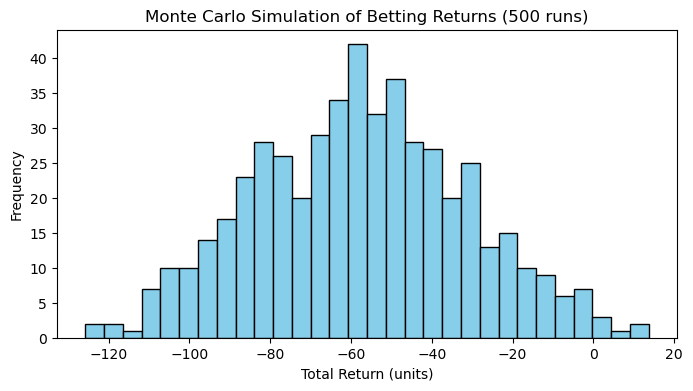

Mean return: -57.75 units
Median return: -57.55 units
Std dev of return: 26.29 units
Best return: 13.74 units
Worst return: -125.82 units


In [214]:
# --- Monte Carlo Simulation of XGBoost Betting Strategy ---

def monte_carlo_betting(sim_df, n_simulations=100, stake=1, random_seed=42):
    np.random.seed(random_seed)
    total_returns = []
    num_bets_list = []
    for sim in range(n_simulations):
        bet_results = []
        num_bets = 0
        for idx, row in sim_df.iterrows():
            # Randomly skip some bets to simulate randomness (e.g., 80% chance to bet)
            if np.random.rand() < 0.2:
                # Home win
                if row['Fair_H'] < row['B365H']:
                    win = 1 if row['Result'] == 0 else 0
                    payout = (row['B365H'] * stake) if win else 0
                    profit = payout - stake
                    bet_results.append(profit)
                    num_bets += 1
                # Draw
                if row['Fair_D'] < row['B365D']:
                    win = 1 if row['Result'] == 1 else 0
                    payout = (row['B365D'] * stake) if win else 0
                    profit = payout - stake
                    bet_results.append(profit)
                    num_bets += 1
                # Away win
                if row['Fair_A'] < row['B365A']:
                    win = 1 if row['Result'] == 2 else 0
                    payout = (row['B365A'] * stake) if win else 0
                    profit = payout - stake
                    bet_results.append(profit)
                    num_bets += 1
        total_returns.append(sum(bet_results))
        num_bets_list.append(num_bets)
    return total_returns, num_bets_list

# Run the simulation
n_simulations = 500
returns, bets = monte_carlo_betting(sim_df, n_simulations=n_simulations)

# Plot results
plt.figure(figsize=(8,4))
plt.hist(returns, bins=30, color='skyblue', edgecolor='k')
plt.title(f'Monte Carlo Simulation of Betting Returns ({n_simulations} runs)')
plt.xlabel('Total Return (units)')
plt.ylabel('Frequency')
plt.show()

print(f"Mean return: {np.mean(returns):.2f} units")
print(f"Median return: {np.median(returns):.2f} units")
print(f"Std dev of return: {np.std(returns):.2f} units")
print(f"Best return: {np.max(returns):.2f} units")
print(f"Worst return: {np.min(returns):.2f} units")

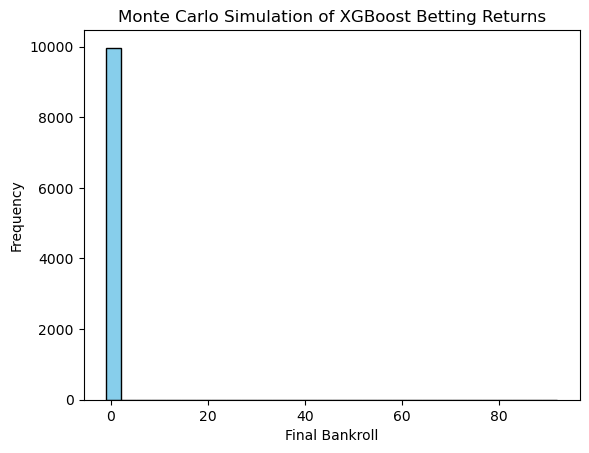

Mean final bankroll: -0.35
Median final bankroll: -0.45
Std dev of final bankroll: 2.45
Best final bankroll: 92.01
Worst final bankroll: -1.00


In [ ]:
# --- Monte Carlo Betting Simulation Alternative 1 ---
def monte_carlo_betting_simulation(data, num_simulations=10000, bankroll=100, bet_size=1):
    """
    Simulate betting outcomes using Monte Carlo
    
    Parameters:
    - data: DataFrame with your betting history
    - num_simulations: Number of simulations to run
    - bankroll: Starting bankroll
    - bet_size: Fixed bet amount
    
    Returns:
    - Array of final bankroll values from all simulations
    """
    
    # Get win probabilities and odds from your data
    win_prob = len(data[data['Win'] == 1]) / len(data)
    avg_odds = data[data['Win'] == 1]['Odds'].mean()
    
    final_bankrolls = []
    
    for _ in range(num_simulations):
        current_bankroll = bankroll
        num_bets = len(data)
        
        # Simulate each bet
        for _ in range(num_bets):
            if current_bankroll <= 0:
                break  # Stop if bankrupt
                
            # Random outcome based on win probability
            if np.random.random() < win_prob:
                current_bankroll += bet_size * (avg_odds - 1)  # Win
            else:
                current_bankroll -= bet_size  # Loss
                
        final_bankrolls.append(current_bankroll)
    
    return np.array(final_bankrolls)

# Run simulation
final_balances = monte_carlo_betting_simulation(bet_report_df)

# Plot results
plt.hist(final_balances, bins=30, color='skyblue', edgecolor='k')
plt.title('Monte Carlo Simulation of XGBoost Betting Returns')
plt.xlabel('Final Bankroll')
plt.ylabel('Frequency')
plt.show()

print(f"Mean final bankroll: {np.mean(final_balances):.2f}")
print(f"Median final bankroll: {np.median(final_balances):.2f}")
print(f"Std dev of final bankroll: {np.std(final_balances):.2f}")
print(f"Best final bankroll: {np.max(final_balances):.2f}")
print(f"Worst final bankroll: {np.min(final_balances):.2f}")

In [ ]:
# --- Risk of Ruin Analysis ---
def risk_of_ruin_simulation(data, num_simulations=10000, bankroll=100):
    """Calculate probability of losing entire bankroll"""
    win_prob = len(data[data['Win'] == 1]) / len(data)
    avg_odds = data[data['Win'] == 1]['Odds'].mean()
    bet_size = 1  # Fixed bet amount
    
    ruin_count = 0
    
    for _ in range(num_simulations):
        current = bankroll
        for _ in range(len(data)):
            if current <= 0:
                ruin_count += 1
                break
                
            if np.random.random() < win_prob:
                current += bet_size * (avg_odds - 1)
            else:
                current -= bet_size
                
    return ruin_count / num_simulations

ruin_prob = risk_of_ruin_simulation(bet_report_df)
print(f"Probability of losing entire bankroll: {ruin_prob:.2%}")

Probability of losing entire bankroll: 99.63%


In [ ]:
# --- Monte Carlo Betting Simulation Alternative 2 ---
def advanced_monte_carlo(data, num_simulations=1000, bankroll=100):
    """Simulate using actual odds and outcomes from your data"""
    final_values = []
    num_bets = len(data)
    
    for _ in range(num_simulations):
        current = bankroll
        # Shuffle the order of bets
        shuffled = data.sample(frac=1).reset_index(drop=True)
        
        for i in range(num_bets):
            if current <= 0:
                break
                
            bet = shuffled.iloc[i]
            if np.random.random() < (1 / bet['FairOdds']):  # Using fair odds as true probability
                current += (bet['Odds'] - 1)  # Win
            else:
                current -= 1  # Loss
                
        final_values.append(current)
    
    return np.array(final_values)

# Run the advanced simulation
advanced_results = advanced_monte_carlo(bet_report_df)

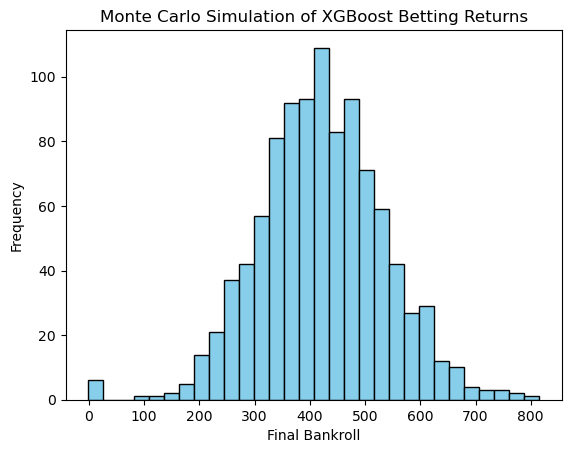

Mean final bankroll: 421.63
Median final bankroll: 419.09
Std dev of final bankroll: 113.94
Best final bankroll: 815.49
Worst final bankroll: -0.72


In [ ]:
# Plot results
import matplotlib.pyplot as plt
plt.hist(advanced_results, bins=30, color='skyblue', edgecolor='k')
plt.title('Monte Carlo Simulation of XGBoost Betting Returns')
plt.xlabel('Final Bankroll')
plt.ylabel('Frequency')
plt.show()

print(f"Mean final bankroll: {np.mean(advanced_results):.2f}")
print(f"Median final bankroll: {np.median(advanced_results):.2f}")
print(f"Std dev of final bankroll: {np.std(advanced_results):.2f}")
print(f"Best final bankroll: {np.max(advanced_results):.2f}")
print(f"Worst final bankroll: {np.min(advanced_results):.2f}")

In [ ]:
# --- Baseline Betting Strategy: Always Bet on Home Team ---

stake = 1  # 1 unit per bet
bet_results = []

for idx, row in sim_df.iterrows():
    # Always bet on home win
    win = 1 if row['Result'] == 0 else 0
    payout = (row['B365H'] * stake) if win else 0
    profit = payout - stake
    bet_results.append(profit)

total_return = sum(bet_results)
num_bets = len(bet_results)
avg_return = total_return / num_bets if num_bets > 0 else 0

print(f"Total return: {total_return:.2f} units")
print(f"Number of bets: {num_bets}")
print(f"Average return per bet: {avg_return:.3f} units")

Total return: -210.49 units
Number of bets: 1747
Average return per bet: -0.120 units


In [215]:
# --- Baseline Betting Strategy: Always Bet on Draw ---

stake = 1  # 1 unit per bet
bet_results = []

for idx, row in sim_df.iterrows():
    # Always bet on draw
    win = 1 if row['Result'] == 1 else 0
    payout = (row['B365D'] * stake) if win else 0
    profit = payout - stake
    bet_results.append(profit)

total_return = sum(bet_results)
num_bets = len(bet_results)
avg_return = total_return / num_bets if num_bets > 0 else 0

print(f"Total return: {total_return:.2f} units")
print(f"Number of bets: {num_bets}")
print(f"Average return per bet: {avg_return:.3f} units")

Total return: 20.62 units
Number of bets: 1747
Average return per bet: 0.012 units


In [ ]:
# --- Baseline Betting Strategy: Bet on Most Probable Bookmaker Outcome ---

stake = 1  # 1 unit per bet
bet_results = []

for idx, row in sim_df.iterrows():
    # Find the outcome with the smallest odds (most probable)
    odds = {'H': row['B365H'], 'D': row['B365D'], 'A': row['B365A']}
    min_outcome = min(odds, key=odds.get)
    min_odd = odds[min_outcome]
    
    # Determine if the bet was a win
    if min_outcome == 'H':
        win = 1 if row['Result'] == 0 else 0
    elif min_outcome == 'D':
        win = 1 if row['Result'] == 1 else 0
    else:  # 'A'
        win = 1 if row['Result'] == 2 else 0
    
    payout = (min_odd * stake) if win else 0
    profit = payout - stake
    bet_results.append(profit)

total_return = sum(bet_results)
num_bets = len(bet_results)
avg_return = total_return / num_bets if num_bets > 0 else 0

print(f"Total return: {total_return:.2f} units")
print(f"Number of bets: {num_bets}")
print(f"Average return per bet: {avg_return:.3f} units")

Total return: -6.98 units
Number of bets: 1747
Average return per bet: -0.004 units
